# Dynamic Time Warping for STRING data

#### DTW Formula

DTW finds the alignment   
$ (X_{i(s)},Y_{j(s)} ) \text{  for } s=1 ... N $   
that minimizes:   
$ \sum_s  ||X_{i(s)}- Y_{j(s)}|| + TC(d_i,d_j) $      with: $ d_i = i(s)-i(s-1), d_j = j(s)-j(s-1) $

+ with $|| ... ||$ denoting a *local distance metric* that measures distance between string elements
+ subject to the constraint that $i$ and $j$ need to *progress* in time, i.e. $i(s+1) >= i(s)$
+ specific transition constraints and/or costs that are algorithm specific (they can both be additive and multiplicative)



In [1]:
# Do the imports #
##################
#
%matplotlib inline
import os,sys 
import numpy as np
import math

import pandas as pd
from IPython.display import display, Audio, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import Box, HBox, VBox, Layout,interactive
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
#

import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.dtw as dtw

    
# make notebook cells stretch over the full screen
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

## Utility functions for string matching
Below a couple very much ad hoc similarity functions for characters are defined

In [2]:
#
# Define a few utility functions that deal with character match/mismatch
#
def letter_class(a):
    if a.lower() in 'aeiou' : return('VOWEL')
    elif a.lower() in 'pbtdkg' : return('PLOSIVE')
    elif a.lower() in 'mnlr' : return('LIQUID')
    elif a.lower() in 'sfzvc' : return('FRICATIVE')
    else: return(None)
    
def letter_sym(a,b):
    '''
    a very ad hoc sound similarity measure between letters
    returns
        0: a == b
        1: class(a) == class(b)  for defined classes 
        2: otherwise
    '''
    _DIFFERENT = 1.
    _SIMILAR = .6
    _SAME = 0
    
    if a == b: return(_SAME)
    class_a = letter_class(a)
    class_b = letter_class(b)
    if class_a is None or class_b is None: return(_DIFFERENT)
    if class_a == class_b: return(_SIMILAR)
    else: return(_DIFFERENT)

def letter_sym_matrix(x,y):
    '''
    constructs sound similarity matrix for arrays x and y
    '''
    x = x.flatten()
    y = y.flatten()
    Nx = len(x)
    Ny = len(y)
    dist_matrix = np.zeros((Nx,Ny),dtype='float32')
    for i in range(Nx):
        for j in range(Ny):
            dist_matrix[i,j] = letter_sym(x[i],y[j])
    return(dist_matrix)

def ld_rand(x,y):
    Nx = len(x)
    Ny = len(y)
    dist_matrix = np.random.rand(Nx,Ny) 
    return(dist_matrix)

In [7]:
def plot_trellis3(x,y,mat,bptrs,trace,figsize=(10,5),**plt_args):
    '''
    side by side plot of backtracking and backtrace
    '''
    fig = plt.figure( figsize=figsize )
    subfigs = fig.subfigures(1, 2, wspace=.01)
    dtw.plot_trellis(fig=subfigs[0],x=x,y=y,xy_mat=mat,bptrs=bptrs,**plt_args)
    dtw.plot_trellis(fig=subfigs[1],x=x,y=y,xy_mat=mat,trace=trace,**plt_args)    
    return(fig)

## Levenshtein Distance between strings

Levenshtein distance is defined as a string edit matching approach allowing for 3 basic operations: 
* Subsititution, Insertion, Deletion *.  


#### DTW or EditDistance algorithms for string matching ?

A classical Levenshtein string edit matching or DTW are sequence matching algorithms based on the same principles.
However, there are a few subtle differences.
- Edit Distance:
    + without INSERTION/DELETION transition costs  'l' will be a perfect match for 'll' in DTW. In Levenshtein this is INS or DEL
- Alignments:
    + DTW will return an alignement consisting of character pairs $(X_i,Y_j)$
    + Levenshtein alignments are EPS-alignments, i.e. the look the same but allow for EPSILON characters to flag INSERTIONS and DELETIONS
- The DTW algorithm can be made to perform identical as LEVENSHTEIN with following precautions:
    + Add insertion and deletion costs in the DTW horizontal/vertical moves
    + Add a dummy initial symbol to both strings before performing DTW, to allow for correct interpretation of initial INS/DEL
    + Convert the original DTW alignment to an EPS-alignment by detecting INS/DEL on the alignment
    
    
With the DTW algorithm it is implemented by:
- local distance =: 0 if match between characters, 1 otherwise
- only 3 types of transitions are allowed:
    + (+1,+1): match or substitution  (diagonal move)
    + (+1,0):  insertion (horizontal move)
    + (0,+1):  deletion  (vertical move)
    + a penalty of '1' is applied to horizonta/vertical transitions

**X, Y - CONVENTIONS**
- In se the Levenshtein and this version of DTW are symmetric, hence it is not so relevant what you call x or y
- What is 'x' or 'y' becomes relevant when you start talking about INSERTIONS and DELETIONS, we use following conventions:
    + INSERTIONS or DELETIONS are defined as operating on REFERENCE (y) to obtain OBSERVATION (x)
    + dtw.dtw(x,y) is called with 'x' as first and 'y' as second argument
    + x-axis is the horizontal axis, y-axis is the vertical axis (mostly pointing DOWN)

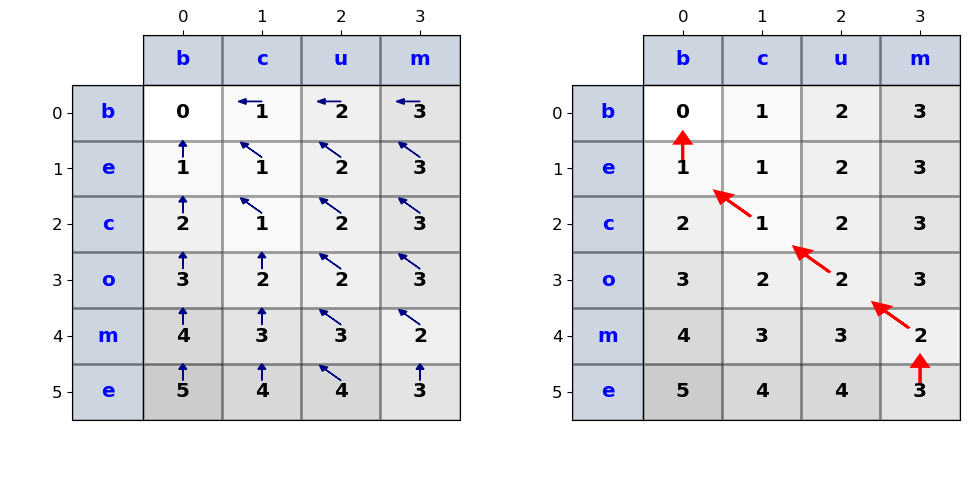

In [11]:
# Example1:  choose one of the word pairs below
xy = ['bcum','become']
#xy = ['#works','#sword']
#xy = ['#worlds','#sword']
#xy = ['swallow','saloon']
x_str = np.array(list(xy[0]))
y_str = np.array(list(xy[1]))  
plt_args = {'xy_annot':True,'ftr_annot':True,'fig_width':3.5,'ftr_scale':.15,
            'xy_args':{'cmap':'Greys','alpha':.2,'text_size':'large','fontweight':'bold','fmt':'{:.0f}'},
            'ftr_args':{'alpha':.2,'cmap':'Blues','text_color':'b','text_size':'large','fontweight':'bold'}}

dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_str,y_str,trans='LEV',result='details',p="hamming")
#fig = dtw.plot_trellis2(x_str,y_str,ld_matrix,cd_matrix,trace,figsize=(10,5),**plt_args)
fig = plot_trellis3(x_str,y_str,cd_matrix,bptrs,trace,figsize=(10,5),**plt_args)
display(fig)

In [12]:
print("DTW distance = ",dist)
print("DTW Alignment")
display(dtw.align(x_str,y_str,trace).T)
print("Edit Distance Alignment")
display(dtw.align(x_str,y_str,trace,EPS="_").T)

DTW distance =  3.0
DTW Alignment


,0,1,2,3,4,5
x,b,b,c,u,m,m
y,b,e,c,o,m,e


Edit Distance Alignment


,0,1,2,3,4,5
x,b,_,c,u,m,_
y,b,e,c,o,m,e
E,H,D,H,S,H,D


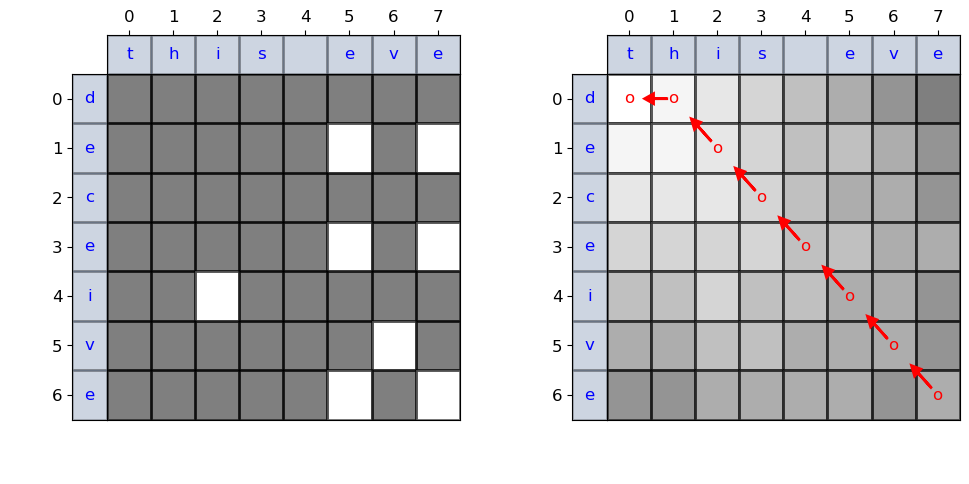

In [5]:
# Add a dummy symbol at beginning if you want to allow for initial insertions/deletions
syms = ['nebukadnezar','nabukodonosor']
#syms = ['volodomir','vladimirski']
#syms= ['recognize speech','wreck a nice beach']
#syms = ['in the skies','in disguise']
#syms = ['albert einstein','max levenshtein']
#syms = ['law and order','laura norder']
syms = ['this evening','deceiving']
syms = ['this eve','deceive']
#
x_str = np.array(list(syms[0]))
y_str = np.array(list(syms[1]))  
plt_args = {'xy_annot':False,'ftr_annot':True,'fig_width':6,'ftr_scale':.1,
            'xy_args':{'cmap':'Greys','alpha':.5,'text_size':'x-small','fmt':'{:.1f}'},
            'ftr_args':{'alpha':.2,'cmap':'Blues','text_color':'b','text_size':'medium'}}
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_str,y_str,trans='LEV',result='details',p="hamming")                                   
fig = dtw.plot_trellis2(x_str,y_str,ld_matrix,cd_matrix,trace,**plt_args)
display(fig)

In [6]:
print("DTW distance = ",dist)
display(dtw.align(x_str,y_str,trace,EPS="_").T)

DTW distance =  6.0


,0,1,2,3,4,5,6,7
x,t,h,i,s,,e,v,e
y,d,_,e,c,e,i,v,e
E,S,I,S,S,S,S,H,H


## Character mismatch costs
Character specific mismatch costs are easily added to the concept when using the DTW algorithm to implement Levenshtein style sequence matching.  In the example below we pass our very ad hoc 'letter_sym_matrix' similarity function which gives smaller penalties when
vowels match vowels, plosives match plosives, ..

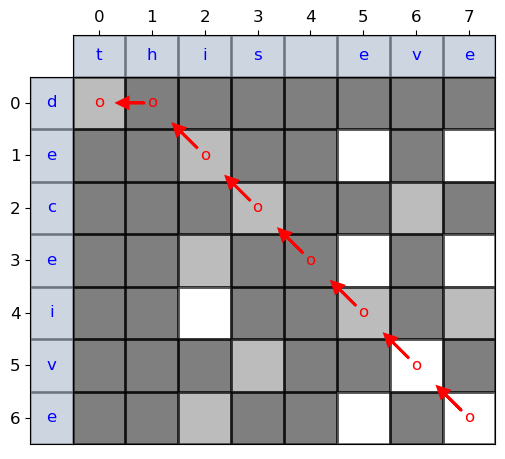

DTW distance =  4.400000095367432


,0,1,2,3,4,5,6,7
x,t,h,i,s,,e,v,e
y,d,_,e,c,e,i,v,e
E,S,I,S,S,S,S,H,H


In [7]:
dist,trace,ld_matrix,cd_matrix,bptrs = dtw.dtw(x_str,y_str,trans='LEV', ld_func=letter_sym_matrix,result='details',p="hamming")
                                               
fig = dtw.plot_trellis(x=x_str,y=y_str,xy_mat=ld_matrix,trace=trace,**plt_args)
display(fig)
print("DTW distance = ",dist)
display(dtw.align(x_str,y_str,trace,EPS='_').T)

## ERROR RATE COMPUTATIONS with DTW

For each sentence in your corpus:
- compare **REFERENCE** (given transcription) with **OBSERVATION** (result from speech recognition)
- accumulate 
    + number of words (in the REFERENCE)
    + number of errors (possibly split out for INSERTIONS/DELETIONS/SUBSITUTIONS)
    + report the composite error rate(s)

In [8]:
references =[
    "fauchelevent limped along behind the horse in a very contented frame of mind ",
    " he would have loved to be king in such a non nonsense paradise ",
    "do you know the names of the seven dwarfs in Disney’s Snow White movie ?"]

observations =[
    "lochleven limped along behind the heard in very contented frame of mind",
    " he had loved the king in a no sense paradigm",
    "do you know the names of the seven warfs in the sneaze now white movie ?"]

total_edits = 0
total_words = 0
for obs,ref in zip( observations,references ):
    x = np.array(obs.split())
    y = np.array(ref.split())
    d,tr = dtw.dtw(x,y,p='hamming')
    display(dtw.align(x,y,tr,EPS='_').T)
    nwords = len(y)
    print("#Edits in this sentence: %d/%d "%(d,nwords))
    total_edits+=d
    total_words+=nwords
print("\nTotal number of edits in the corpus: %d/%d" %(total_edits,total_words))
print("\nError rate for this corpus: %.2f%%" % ((100.0*total_edits)/total_words))

,0,1,2,3,4,5,6,7,8,9,10,11,12
x,lochleven,limped,along,behind,the,heard,in,_,very,contented,frame,of,mind
y,fauchelevent,limped,along,behind,the,horse,in,a,very,contented,frame,of,mind
E,S,H,H,H,H,S,H,D,H,H,H,H,H


#Edits in this sentence: 3/13 


,0,1,2,3,4,5,6,7,8,9,10,11,12
x,he,_,had,loved,_,the,king,in,_,a,no,sense,paradigm
y,he,would,have,loved,to,be,king,in,such,a,non,nonsense,paradise
E,H,D,S,H,D,S,H,H,D,H,S,S,S


#Edits in this sentence: 8/13 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
x,do,you,know,the,names,of,the,seven,warfs,in,the,sneaze,now,white,movie,?
y,do,you,know,the,names,of,the,seven,dwarfs,in,_,Disney’s,Snow,White,movie,?
E,H,H,H,H,H,H,H,H,S,H,I,S,S,S,H,H


#Edits in this sentence: 5/15 

Total number of edits in the corpus: 16/41

Error rate for this corpus: 39.02%
